In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', -1)

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import openslide
from numpy import asarray

In [5]:
class TMA:
    diameter_spot = 1200
    def __init__(self, tma_path, file, img_path_tif):
        self.meta_fn = file
        self.meta_path = tma_path
        self.img_path_tif = img_path_tif
        self.name = file.strip('.txt')[len('TMA results - '):]
        self.spots = self.load_spots_meta()
        self.img_tif = self.load_img_tif()
        
    def load_tma_meta(self):
        df1 = pd.read_csv(os.path.join(self.meta_path, self.meta_fn), names=['fn', 'missing','X', 'Y', 'ID'], sep='\t', skiprows=[0])
        return df1
    
    def load_img_tif(self):
        a = None
        try:
            a = openslide.OpenSlide(os.path.join(self.img_path_tif, self.name + '.tif'))
        except: 
            print(self.name + '.tif')
        return a
    
    def load_spots_meta(self):
        spots = []
        for index, rows in self.load_tma_meta().iterrows():
            spots.append(Spot(self.diameter_spot, 
                              rows.fn, rows.missing, (rows.X, rows.Y), rows.ID,
                        self.meta_path, self))
        return spots


In [10]:
class Spot: 
    def __init__(self, diameter, name, missing, center, ID, img_path_jpg, tma):
        self.path_jpg = img_path_jpg
        self.diameter = diameter #in micrometers
        self.name = name
        self.center = center #in micrometers
        self.missing = missing
        self.ID = ID
        self.TMA = tma
        self.tiles = []
        
        
        
    def load_img_jpg(self):
        s = openslide.ImageSlide(os.path.join(self.path_jpg, self.name + '.jpg'))
        #regions to be read with method s.read_region()
        return s
    
    #get spot center coordinates in pixels
    def get_center_pixel(self):
        tma = self.TMA.img_tif
        c_x, c_y = self.center 
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y']) #mpp  - 0.25  micras per pixel
        pc_x, pc_y = int(c_x / float(mpp_x)),int(c_y / float(mpp_y))
        return pc_x, pc_y
    
    #return radious in pixels both at full magnification (level = 0) and at a given zoom-out level
    def get_radious_pixel(self, level):
        tma = self.TMA.img_tif
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y'])
        #mpp = (mpp_x**2 + mpp_y**2)**0.5
        pspot_radio = int(self.diameter/ mpp_x / 2 )
        pzoom_radio = int( pspot_radio/ 2**level ) #with each increasing level the image is reduced half size 
        return pspot_radio, pzoom_radio
    
    #return spot circunference's north and sud y-coordinates (absolute positions in level 0) 
    #given a relative position from 0 (left) to 1 (right) in the spot diameter in axis x
    def get_circle_coordinates_pixel(self, rel_pos_diameter_x = .5): #return by default the y-coordinates for x fixed at center
        pc_x, pc_y = self.get_center_pixel()
        pspot_radio, _ = self.get_radious_pixel(0)
        x = int(pc_x - pspot_radio + rel_pos_diameter_x*(pspot_radio*2))
        if (( x + pspot_radio < pc_x) or ( x - pspot_radio > pc_x)): #x should be in circle diameter (pc_x - pspot_radio, pc_x + pspot_radio)
            return x, np.nan, np.nan
        root = (pspot_radio**2 - (x - pc_x)**2)**0.5
        y_north = int( -root + pc_y)
        y_sud = int( root + pc_y)
        return x, y_north, y_sud
    
    #check (true or false) if there is scarce tissue in an image
    def check_scarce_tissue(self, tile_image): 
        s = asarray(tile_image)
        return s.mean() >= 230 #completely white = 255
   
    #return an image tile from the spot where x,y is the left-sup corner of the tile
    #for reference for current scanned tifs properties, level 0 is fully magnified image and for level 4 encloses one spot of diameter 1.2 micrometers
    def get_tile(self, x,y , size=(300,300) , level = 4):
        tma = self.TMA.img_tif
        image = tma.read_region((x,y),level,size)
        if self.check_scarce_tissue(image):
            return np.nan
        else:
            return image

    
    
    #check (true or false) that tile (defined by left sup coordinate and size in a zoom level) is enclosed in a box defined by the 4 spot poles 
    def check_tile_in_spot(self, x,y,size=(300,300) , level = 4):
        spot_poles = (self.get_circle_coordinates_pixel(0)[0], #left
                  self.get_circle_coordinates_pixel(1)[0],  #right
                  self.get_circle_coordinates_pixel(0.5)[1], #north
                  self.get_circle_coordinates_pixel(0.5)[2]) #sud
        if (x < spot_poles[0]) or (y < spot_poles[2] ) or (x + size[0]*(2**level) > spot_poles[1] ) or (y + size[1]*(2**level) > spot_poles[3]):
            return False, spot_poles
        else:
            return True, spot_poles
        
        
    #given a tile size in pixels and zoom level then sample all possible tiles from spot 
    #with a given overlap (0 to <1)
    #return all tiles (defined by sup-lef corner coordinates, size and level) 
    #enclosed in box-spot with enough tissue 
    def sample_tiles(self, size = (300,300), level = 4, overlap = .2):
        pspot_radio, _ = self.get_radious_pixel(level)
        spot_tile_ratio = pspot_radio * 2 / size[0] 
        spot_tile_ratio_by_zoom = spot_tile_ratio / 2**level 
        stride_norm = 1 - overlap
        print(np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom))
        for i_x in np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom): 
            x, y_north, y_sud = self.get_circle_coordinates_pixel(i_x)
            if (y_sud-y_north == 0): #intersection of ecuador with circunference
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north), size, level])
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north) - pspot_radio, size, level])
            else:
                for j in np.arange(y_north, y_sud, (y_sud-y_north)*stride_norm/spot_tile_ratio_by_zoom ): 
                    if self.check_tile_in_spot(x, int(j), size, level)[0]:
                        self.tiles.append([x, int(j), size, level])

        return self.tiles
    
    

    #given a zoom level it returns the box enclosing only this spot
    def get_enclosing_box(self, level):
        pspot_radio, pzoom_radio = self.get_radious_pixel(level)
        print(pzoom_radio)
        pc_x, pc_y = spot.get_center_pixel()
        tile = spot.get_tile(pc_x - pspot_radio, pc_y - pspot_radio,  (pzoom_radio * 2, pzoom_radio * 2), level )
        return tile
    

    
        

In [14]:
import os
tmas = []
for root, dirs, files in os.walk("SPOTS"):
    for file in files:
        if file.endswith(".txt"):
            tma = TMA(root, file, 'DTS2019')
            tmas.append(tma)
            
           
             
            

In [15]:
tma = tmas[1]

print(tma.meta_path)
print(tma.img_path_tif)

print(tma.spots[2].center)
spot = tma.spots[5]
jpg = spot.load_img_jpg()
tif = tma.load_img_tif()


SPOTS/TMA06-04.qptma.data
DTS2019
(6350.0, 1125.0)


/home/auri/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (101606400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


TMA06-04
1-F
1200
(2400, 2400)
(41100, 5600, 5600)
(True, (41100, 45900, 3200, 8000))


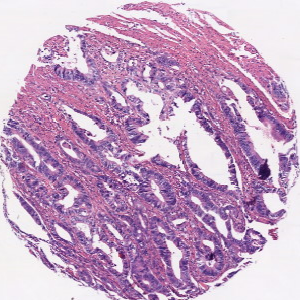

In [16]:
tma.img_tif.properties
print(spot.TMA.name)
print(spot.name)
print(spot.diameter)
spot.get_center_pixel()
print(spot.get_radious_pixel(0))
print(spot.get_circle_coordinates_pixel(0))
print(spot.check_tile_in_spot(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0]))
spot.get_tile(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0])

150
(300, 300)


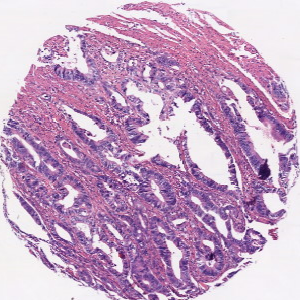

In [17]:
img = spot.get_enclosing_box(4)
print(img.size)
img

In [43]:
spot.tiles = []
print(len(spot.tiles))
for t in spot.sample_tiles(size = (300,300), level = 3, overlap = .2):
    print(t)
    

0
[0.  0.4 0.8]
[41100, 5600, (300, 300), 3]
[41100, 3200, (300, 300), 3]
[43020, 3248, (300, 300), 3]
[43020, 5129, (300, 300), 3]


In [41]:
print(len(spot.tiles))
print(spot.tiles[1])

36429
[41100, 3200, (300, 300), 3]


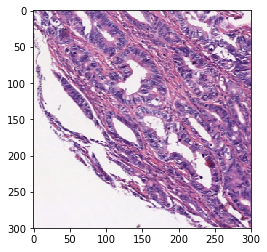

In [45]:
plt.imshow(spot.get_tile(*spot.tiles[0]))

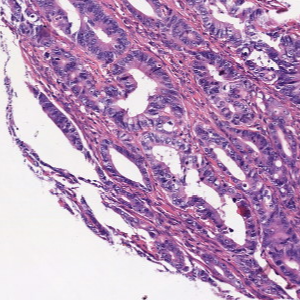

In [47]:
spot.get_tile(*spot.tiles[0])

In [37]:
tma.img_tif.properties

<_PropertyMap {'openslide.comment': 'level=0 mag=40 quality=90', 'openslide.level-count': '10', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '96592', 'openslide.level[0].tile-height': '1024', 'openslide.level[0].tile-width': '1024', 'openslide.level[0].width': '78272', 'openslide.level[1].downsample': '2', 'openslide.level[1].height': '48296', 'openslide.level[1].tile-height': '1024', 'openslide.level[1].tile-width': '1024', 'openslide.level[1].width': '39136', 'openslide.level[2].downsample': '4', 'openslide.level[2].height': '24152', 'openslide.level[2].tile-height': '1024', 'openslide.level[2].tile-width': '1024', 'openslide.level[2].width': '19568', 'openslide.level[3].downsample': '8', 'openslide.level[3].height': '12080', 'openslide.level[3].tile-height': '1024', 'openslide.level[3].tile-width': '1024', 'openslide.level[3].width': '9784', 'openslide.level[4].downsample': '16', 'openslide.level[4].height': '6040', 'openslide.level[4].tile-height': '1024', 'op